# Image editing using instruct-pix2pix
In this notebook we will modify a given image using instructions. These instructions allow us to change image characteristic while keeping the image content. This might be useful for producing multiple similar example images and studying if algorithms, e.g. for segmentation, are capable to process these image variations. We will be using the model [instruct-pix2pix](https://huggingface.co/timbrooks/instruct-pix2pix).

In [1]:
import PIL
import requests
import torch
from skimage.io import imread
import numpy as np
import stackview
from skimage.transform import resize
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

In [2]:
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
            "timbrooks/instruct-pix2pix", 
            torch_dtype=torch.float16, safety_checker=None)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
image_np = imread("data/blobs.tif")
# the model prefers images of specific sizes
scaled_image_np = resize(image_np, (256, 256), preserve_range=True).astype(image_np.dtype)

We need to convert our data in a [Pillow image](https://pillow.readthedocs.io/en/stable/reference/Image.html), a common input format.

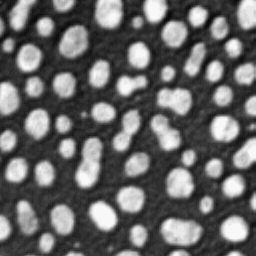

In [4]:
image_rgb_np = np.asarray([scaled_image_np, scaled_image_np, scaled_image_np]).swapaxes(0, 2).swapaxes(0, 1)
image = PIL.Image.fromarray(image_rgb_np)
image

We can then edit the image using a prompt.

C:\Users\haase\miniconda3\envs\genai2\Lib\site-packages\diffusers\models\attention_processor.py:1584: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(


  0%|          | 0/5 [00:00<?, ?it/s]


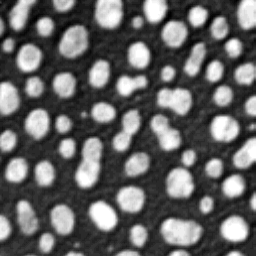

In [5]:
result_image = pipe(prompt="blur the image", 
                    image=image, 
                    num_inference_steps=5, 
                    guidance_scale=1, 
                    image_guidance_scale=1
                   ).images[0]

stackview.animate_curtain(np.array(result_image), scaled_image_np)

StackViewNDArray([[[ 40,  38,  34],
                   [ 39,  40,  36],
                   [ 42,  41,  39],
                   ...,
                   [205, 204, 203],
                   [196, 199, 198],
                   [205, 204, 197]],

                  [[ 39,  37,  36],
                   [ 37,  37,  36],
                   [ 36,  33,  35],
                   ...,
                   [211, 210, 211],
                   [206, 206, 207],
                   [207, 208, 206]],

                  [[ 41,  39,  38],
                   [ 42,  39,  40],
                   [ 42,  37,  40],
                   ...,
                   [218, 218, 219],
                   [212, 213, 213],
                   [213, 215, 211]],

                  ...,

                  [[ 93,  92,  92],
                   [101, 100, 102],
                   [ 96,  95,  95],
                   ...,
                   [ 57,  57,  57],
                   [ 53,  51,  54],
                   [ 58,  55,  57]],

                  [[ 97,  96,  96],
                   [ 99,  98,  99],
                   [ 94,  93,  94],
                   ...,
                   [ 65,  62,  60],
                   [ 57,  57,  58],
                   [ 61,  60,  58]],

                  [[ 88,  87,  90],
                   [ 92,  93,  94],
                   [ 93,  93,  94],
                   ...,
                   [ 61,  60,  63],
                   [ 57,  57,  60],
                   [ 61,  56,  55]]], dtype=uint8)
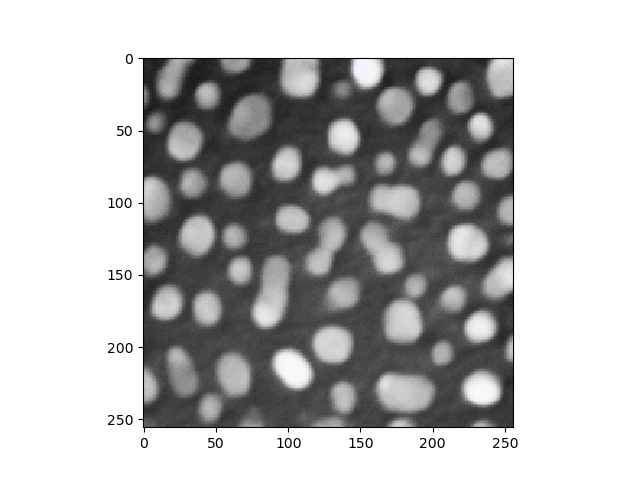
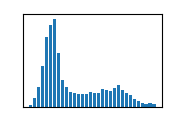

In [6]:
stackview.insight(np.array(result_image))

Note that the model is not trained on scientific images specifically. Thus, it may not know how to edit images using prompts that contain scientific image processing terms. It is capable of modifying images using common terms.

  0%|          | 0/5 [00:00<?, ?it/s]


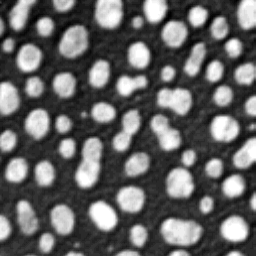

In [7]:
result_image = pipe(prompt="apply a median filter to the image", 
                    image=image, 
                    num_inference_steps=5, 
                    guidance_scale=1, 
                    image_guidance_scale=1
                   ).images[0]

stackview.animate_curtain(np.array(result_image), scaled_image_np)

StackViewNDArray([[[ 50,  46,  39],
                   [ 53,  52,  48],
                   [ 54,  51,  50],
                   ...,
                   [141, 139, 136],
                   [129, 128, 125],
                   [131, 126, 119]],

                  [[ 53,  49,  47],
                   [ 51,  48,  48],
                   [ 51,  48,  47],
                   ...,
                   [142, 141, 139],
                   [139, 138, 135],
                   [123, 120, 116]],

                  [[ 56,  52,  52],
                   [ 69,  68,  67],
                   [ 60,  56,  56],
                   ...,
                   [149, 149, 147],
                   [136, 132, 132],
                   [130, 128, 124]],

                  ...,

                  [[ 96,  93,  93],
                   [ 97,  93,  93],
                   [ 98,  96,  96],
                   ...,
                   [ 58,  56,  55],
                   [ 64,  62,  61],
                   [ 68,  63,  61]],

                  [[ 97,  95,  93],
                   [101,  98,  97],
                   [ 97,  94,  93],
                   ...,
                   [ 69,  62,  61],
                   [ 67,  64,  63],
                   [ 68,  63,  60]],

                  [[ 83,  81,  82],
                   [ 95,  95,  93],
                   [ 96,  95,  93],
                   ...,
                   [ 63,  59,  59],
                   [ 64,  62,  60],
                   [ 51,  46,  39]]], dtype=uint8)
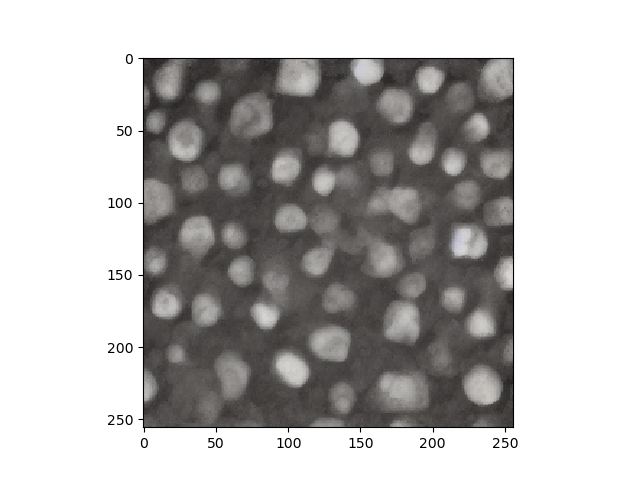
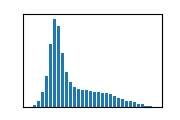

In [8]:
stackview.insight(np.array(result_image))

## Reproducibility
Some prompts are more reproducible than others. We can visualize this by calling the same prompt multiple times.

In [9]:
def display_panel(image, prompts):
    fig, axes = plt.subplots(2, 2, figsize=(15,15))
    
    for i, prompt in enumerate(prompts):
        result_image = pipe(prompt=prompt, 
                            image=image, 
                            num_inference_steps=5, 
                            guidance_scale=1, 
                            image_guidance_scale=1
                           ).images[0]
    
        axes[int(i/2), i%2].imshow(np.array(result_image)[:,:,0], cmap="Greys_r")
        axes[int(i/2), i%2].set_title(prompt)
    
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

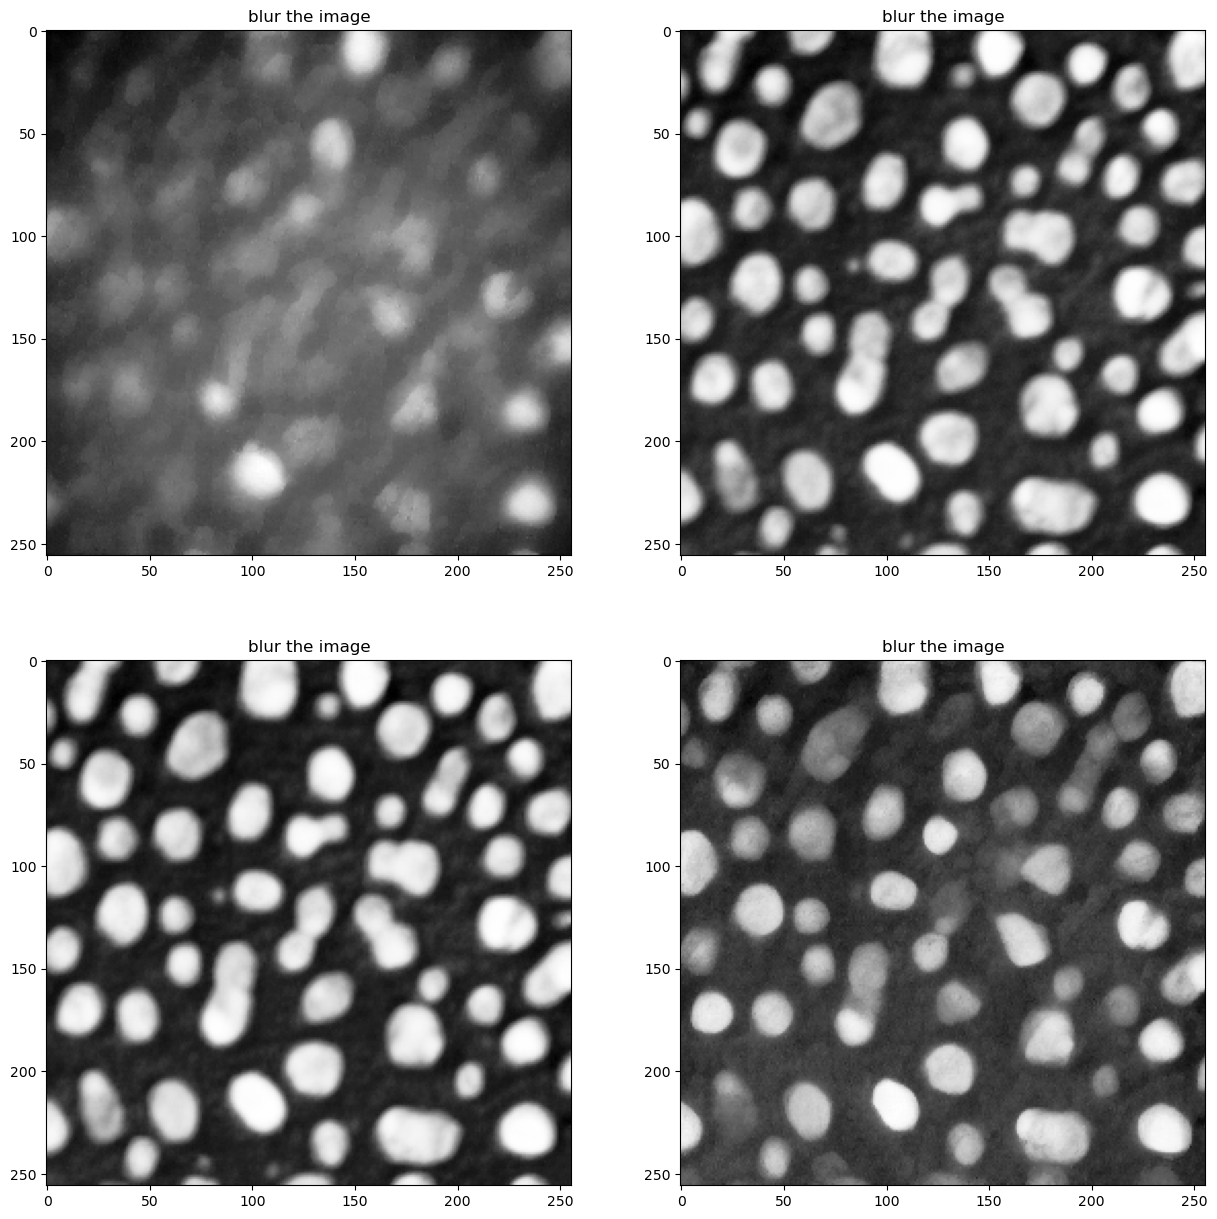

In [10]:
display_panel(image, ["blur the image"] * 4)

## Exercise
Generate more images using example prompts. How reproducible are the results?

In [11]:
prompts = ["apply a median filter to the image",
           "deconvolve the image",
           "blur the image",
           "despeckle the image"]